# Modeling ResNet18

In [28]:
# Basic imports

import pandas as pd
import torch

from torch.utils.data import DataLoader
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Import functions from src

from src.data_loader import (load_json_to_df, multi_hot_encode_row, stratified_train_test_val, CustomMultiLabelDataset,
                             tensor_checker)
from src.transforms import transform_basic, transform_img_aug
from src.models import get_resnet18_model, get_resnet18_model_frozen
from src.train import train_model, get_class_weights, train_model_earlystop_reducelronplateau
from src.utils import plot_train_val_losses
from src.evaluate import evaluate_model_flare

device = "mps" if torch.backends.mps.is_available() else "cpu"

# Set reload updated modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1) Prepare Data for Modeling

In [2]:
LABELS = ['kohaku', 'sanke', 'showa', 'tancho', 'gin']

In [3]:
# Load data
df = load_json_to_df('0_main_dataset/data/df_5labels.json')

# Multi-hot-encode labels
df = multi_hot_encode_row(df, labels=LABELS)

# Stratified train-test-val split
train_df, test_df, val_df = stratified_train_test_val(df['image_path'],
                                                      df['mhe'],
                                                      train_testval_size=0.3,
                                                      test_val_size=0.5,
                                                      print_shapes=False)

# Define the transform

transform = transform_basic()

# Create the datasets

train_ds = CustomMultiLabelDataset(train_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)
test_ds = CustomMultiLabelDataset(test_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)
val_ds = CustomMultiLabelDataset(val_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)

# Create data loaders

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# Check the tensors

tensor_checker(train_loader, test_loader, val_loader)

<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])


In [4]:
# Define the number of classes

num_classes = len(LABELS)
num_classes

5

# MODEL 1: Class Balance

In [5]:
# Use BCEWithLogitsLoss's pos_weights to balance class weights

# step 1: calculate the weights
label_counts = train_df['mhe'].sum(axis=0)
print(f'label_counts: {label_counts}')

total_samples = train_df['mhe'].shape[0]
print(f'total_samples: {total_samples}')

pos_weights = total_samples / label_counts
print(f'pos_weights: {pos_weights}')

pos_weights = torch.tensor(pos_weights, dtype=torch.float32)
pos_weights = pos_weights.to(device)

label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]


In [6]:
# Define the model

model = get_resnet18_model(num_classes)

# Define loss and optimizer

criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model

num_epochs = 20

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model,
                                                                         train_loader,
                                                                         val_loader,
                                                                         criterion,
                                                                         optimizer,
                                                                         device,
                                                                         num_epochs=num_epochs)

Epoch 1/20 | Train Loss: 1.7304, Train Acc: 85.22% | Val Loss: 2.9192, Val Acc: 81.43%
Epoch 2/20 | Train Loss: 0.7091, Train Acc: 93.74% | Val Loss: 0.5151, Val Acc: 93.97%
Epoch 3/20 | Train Loss: 0.5123, Train Acc: 95.81% | Val Loss: 1.3279, Val Acc: 89.05%
Epoch 4/20 | Train Loss: 0.3728, Train Acc: 96.64% | Val Loss: 1.8756, Val Acc: 84.44%
Epoch 5/20 | Train Loss: 0.3608, Train Acc: 96.87% | Val Loss: 0.6487, Val Acc: 94.29%
Epoch 6/20 | Train Loss: 0.2607, Train Acc: 97.54% | Val Loss: 0.2785, Val Acc: 97.30%
Epoch 7/20 | Train Loss: 0.2123, Train Acc: 98.14% | Val Loss: 0.5532, Val Acc: 94.44%
Epoch 8/20 | Train Loss: 0.2024, Train Acc: 97.87% | Val Loss: 0.4282, Val Acc: 94.76%
Epoch 9/20 | Train Loss: 0.1624, Train Acc: 98.70% | Val Loss: 0.9288, Val Acc: 89.37%
Epoch 10/20 | Train Loss: 0.1485, Train Acc: 98.94% | Val Loss: 0.8005, Val Acc: 94.76%
Epoch 11/20 | Train Loss: 0.1393, Train Acc: 98.77% | Val Loss: 0.4026, Val Acc: 96.51%
Epoch 12/20 | Train Loss: 0.1192, Train A

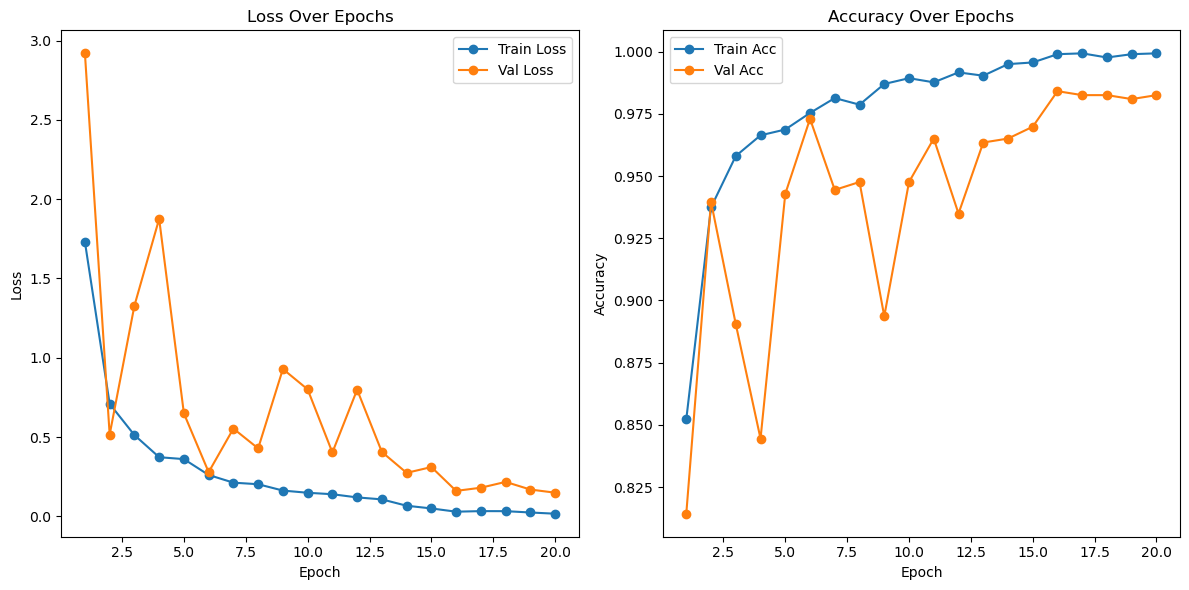

In [7]:
# Plot the train and val losses and accuracies

plot_train_val_losses(num_epochs, train_losses, train_accuracies, val_losses, val_accuracies)

Validation Accuracy: 0.9286, F1 Score: 0.9613, Precision: 0.9809, Recall: 0.9470
              precision    recall  f1-score   support

      kohaku       1.00      1.00      1.00        35
       sanke       1.00      0.79      0.88        14
       showa       0.96      1.00      0.98        43
      tancho       1.00      1.00      1.00        13
         gin       0.95      0.95      0.95        59

   micro avg       0.97      0.96      0.97       164
   macro avg       0.98      0.95      0.96       164
weighted avg       0.97      0.96      0.97       164
 samples avg       0.97      0.97      0.97       164



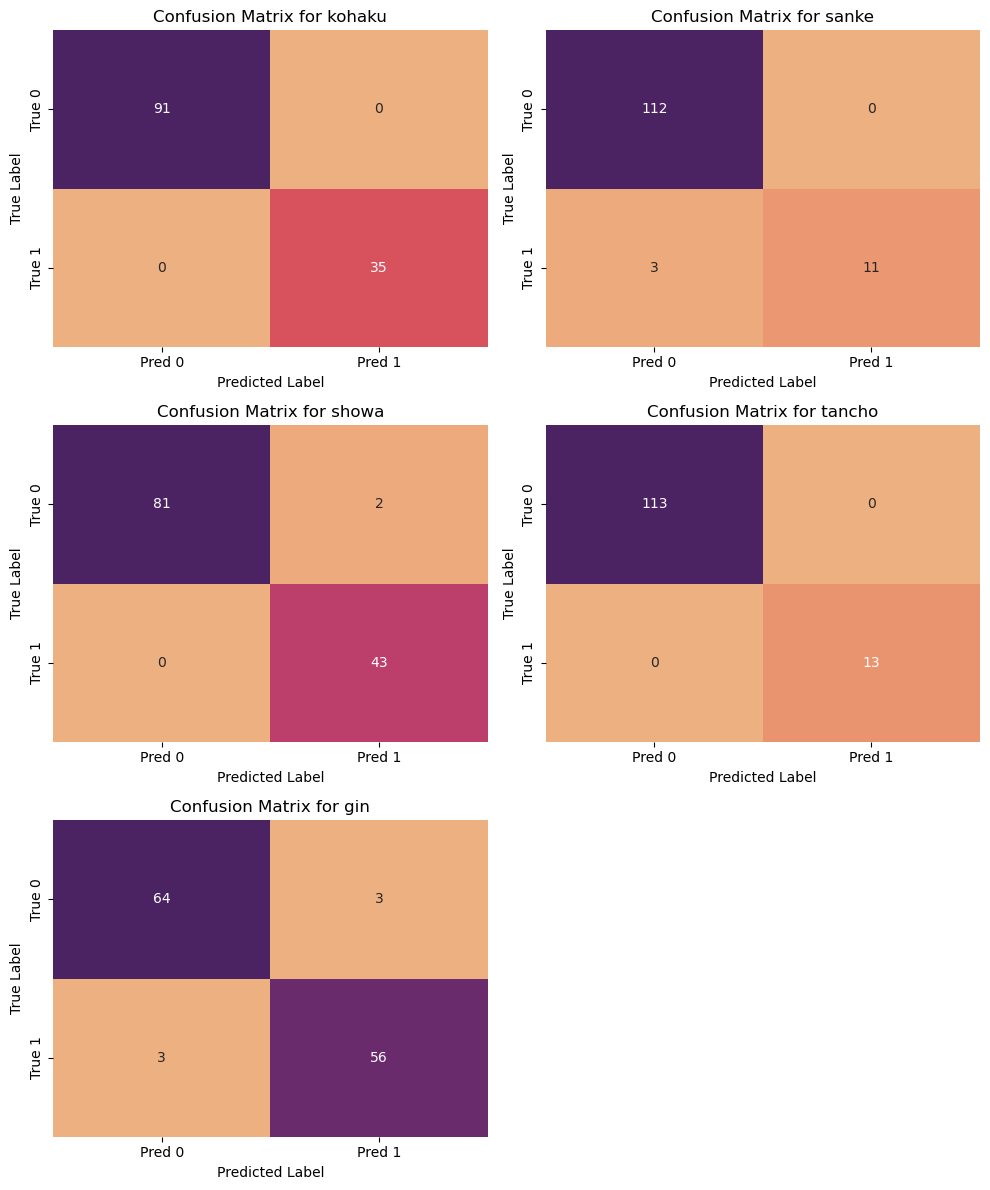

In [9]:
# Evaluate the model

all_preds, all_labels, scores = evaluate_model_flare(model, val_loader, device, class_labels=LABELS)

In [10]:
# Save the model

torch.save(model.state_dict(), 'models/model_resnet18_1_class_balance.pth')

# MODEL 2: Image Augmentation & Reduced Learning Rate

In [11]:
# Define the transform

transform_img_aug = transform_img_aug()
transform = transform_basic()

# Create the datasets

train_ds = CustomMultiLabelDataset(train_df, 'image_path','mhe', dir_path='pictures/', transforms=transform_img_aug)
test_ds = CustomMultiLabelDataset(test_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)
val_ds = CustomMultiLabelDataset(val_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)

# Create data loaders

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# Check the tensors

tensor_checker(train_loader, test_loader, val_loader)

<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])


In [12]:
# Calculate the class balance

pos_weights = get_class_weights(train_df, device)

# Define the model

model = get_resnet18_model(num_classes)

# Define loss and optimizer

criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model

num_epochs = 20

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model,
                                                                         train_loader,
                                                                         val_loader,
                                                                         criterion,
                                                                         optimizer,
                                                                         device,
                                                                         num_epochs=num_epochs)

label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]
Epoch 1/20 | Train Loss: 3.8486, Train Acc: 70.12% | Val Loss: 2.1429, Val Acc: 88.41%
Epoch 2/20 | Train Loss: 1.5172, Train Acc: 92.15% | Val Loss: 1.0996, Val Acc: 94.29%
Epoch 3/20 | Train Loss: 0.8199, Train Acc: 95.84% | Val Loss: 0.6251, Val Acc: 96.35%
Epoch 4/20 | Train Loss: 0.5959, Train Acc: 96.97% | Val Loss: 0.4511, Val Acc: 96.67%
Epoch 5/20 | Train Loss: 0.4878, Train Acc: 97.34% | Val Loss: 0.4538, Val Acc: 97.30%
Epoch 6/20 | Train Loss: 0.3476, Train Acc: 98.74% | Val Loss: 0.2936, Val Acc: 98.25%
Epoch 7/20 | Train Loss: 0.2950, Train Acc: 98.97% | Val Loss: 0.2964, Val Acc: 98.57%
Epoch 8/20 | Train Loss: 0.2449, Train Acc: 99.40% | Val Loss: 0.2808, Val Acc: 98.10%
Epoch 9/20 | Train Loss: 0.2137, Train Acc: 99.53% | Val Loss: 0.2750, Val Acc: 98.25%
Epoch 10/20 | Train Loss: 0.1927, Train Acc: 99.60% | Val Loss: 0.1937, Val Acc: 98.73%

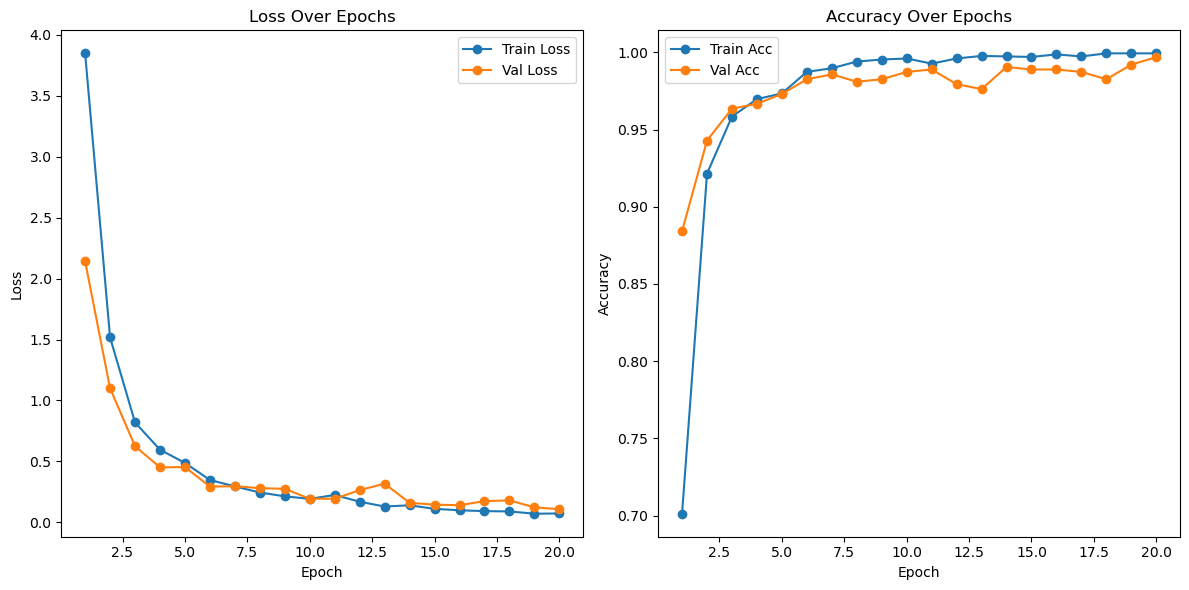

In [13]:
# Plot the train and val losses and accuracies

plot_train_val_losses(num_epochs, train_losses, train_accuracies, val_losses, val_accuracies)

Validation Accuracy: 0.9841, F1 Score: 0.9959, Precision: 1.0000, Recall: 0.9920
              precision    recall  f1-score   support

      kohaku       1.00      1.00      1.00        35
       sanke       1.00      1.00      1.00        14
       showa       1.00      0.98      0.99        43
      tancho       1.00      1.00      1.00        13
         gin       1.00      0.98      0.99        59

   micro avg       1.00      0.99      0.99       164
   macro avg       1.00      0.99      1.00       164
weighted avg       1.00      0.99      0.99       164
 samples avg       1.00      0.99      0.99       164



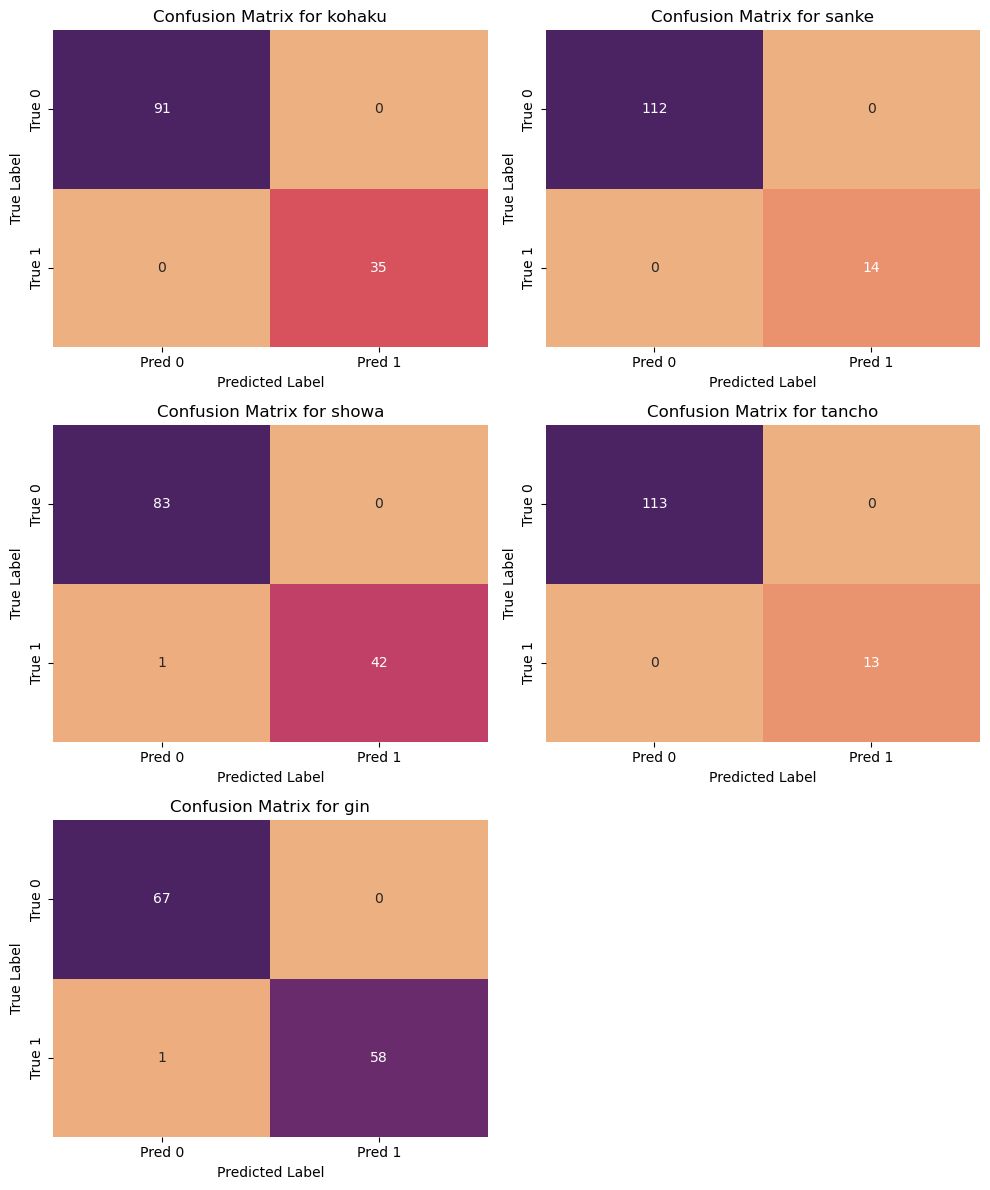

In [14]:
# Evaluate the model

all_preds, all_labels, scores = evaluate_model_flare(model, val_loader, device, class_labels=LABELS)

In [15]:
# Save the model

torch.save(model.state_dict(), 'models/model_resnet18_2_image_augmentation.pth')

# MODEL 3: ReduceLROnPlateau and EarlyStopping

In [16]:
# Calculate the class balance

pos_weights = get_class_weights(train_df, device)

# Define the model

model = get_resnet18_model(num_classes)

# Define loss and optimizer

criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define a scheduler to implement reducing learning rate on plateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Train the model

num_epochs = 20


train_losses, train_accuracies, val_losses, val_accuracies = train_model_earlystop_reducelronplateau(model,
                                                                                                    train_loader,
                                                                                                    val_loader,
                                                                                                    criterion,
                                                                                                    optimizer,
                                                                                                    device,
                                                                                                    scheduler,
                                                                                                    num_epochs=num_epochs,
                                                                                                    patience=3)


label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]


/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 2.5323, Train Acc: 78.97% | Val Loss: 1.5988, Val Acc: 91.43%
Epoch 2/20 | Train Loss: 1.0379, Train Acc: 94.71% | Val Loss: 0.8218, Val Acc: 95.24%
Epoch 3/20 | Train Loss: 0.6207, Train Acc: 96.44% | Val Loss: 0.5203, Val Acc: 96.67%
Epoch 4/20 | Train Loss: 0.4514, Train Acc: 97.57% | Val Loss: 0.4164, Val Acc: 97.30%
Epoch 5/20 | Train Loss: 0.3856, Train Acc: 97.77% | Val Loss: 0.3343, Val Acc: 97.62%
Epoch 6/20 | Train Loss: 0.3466, Train Acc: 98.27% | Val Loss: 0.3578, Val Acc: 96.98%
Epoch 7/20 | Train Loss: 0.2424, Train Acc: 99.03% | Val Loss: 0.3053, Val Acc: 97.94%
Epoch 8/20 | Train Loss: 0.1825, Train Acc: 99.40% | Val Loss: 0.2764, Val Acc: 97.14%
Epoch 9/20 | Train Loss: 0.1548, Train Acc: 99.60% | Val Loss: 0.2277, Val Acc: 98.73%
Epoch 10/20 | Train Loss: 0.1483, Train Acc: 99.53% | Val Loss: 0.1692, Val Acc: 98.89%
Epoch 11/20 | Train Loss: 0.1336, Train Acc: 99.67% | Val Loss: 0.2186, Val Acc: 98.10%
Epoch 12/20 | Train Loss: 0.1128, Train A

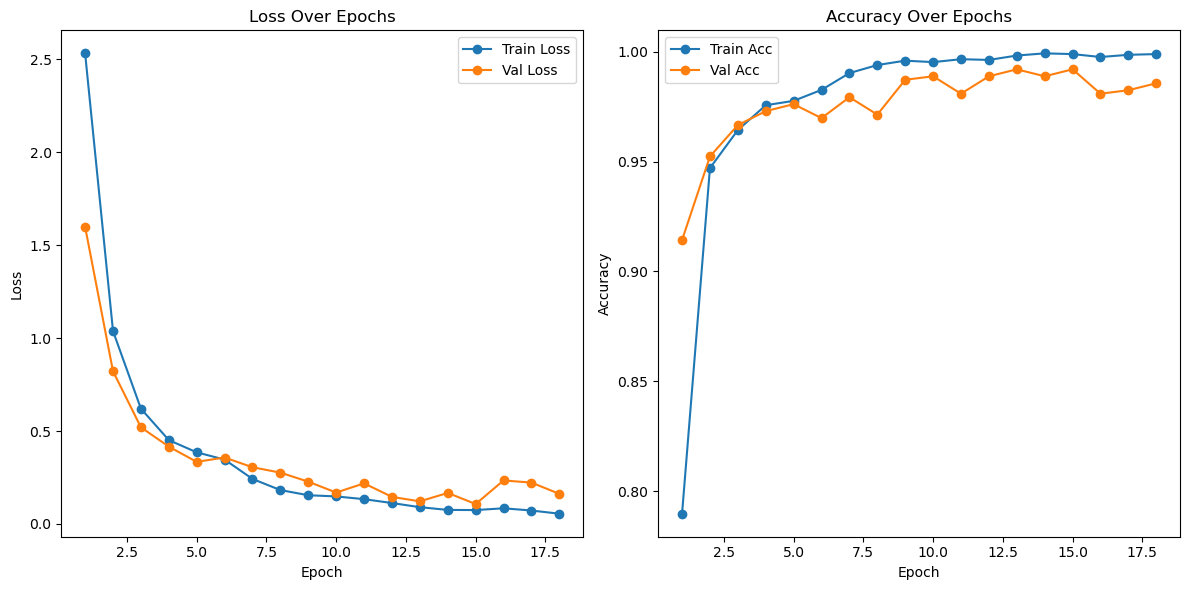

In [20]:
# Plot the train and val losses and accuracies

plot_train_val_losses(len(val_losses), train_losses, train_accuracies, val_losses, val_accuracies)

Validation Accuracy: 0.9524, F1 Score: 0.9682, Precision: 0.9647, Recall: 0.9759
              precision    recall  f1-score   support

      kohaku       1.00      1.00      1.00        35
       sanke       0.82      1.00      0.90        14
       showa       1.00      0.93      0.96        43
      tancho       1.00      1.00      1.00        13
         gin       1.00      0.95      0.97        59

   micro avg       0.98      0.96      0.97       164
   macro avg       0.96      0.98      0.97       164
weighted avg       0.98      0.96      0.97       164
 samples avg       0.98      0.97      0.97       164



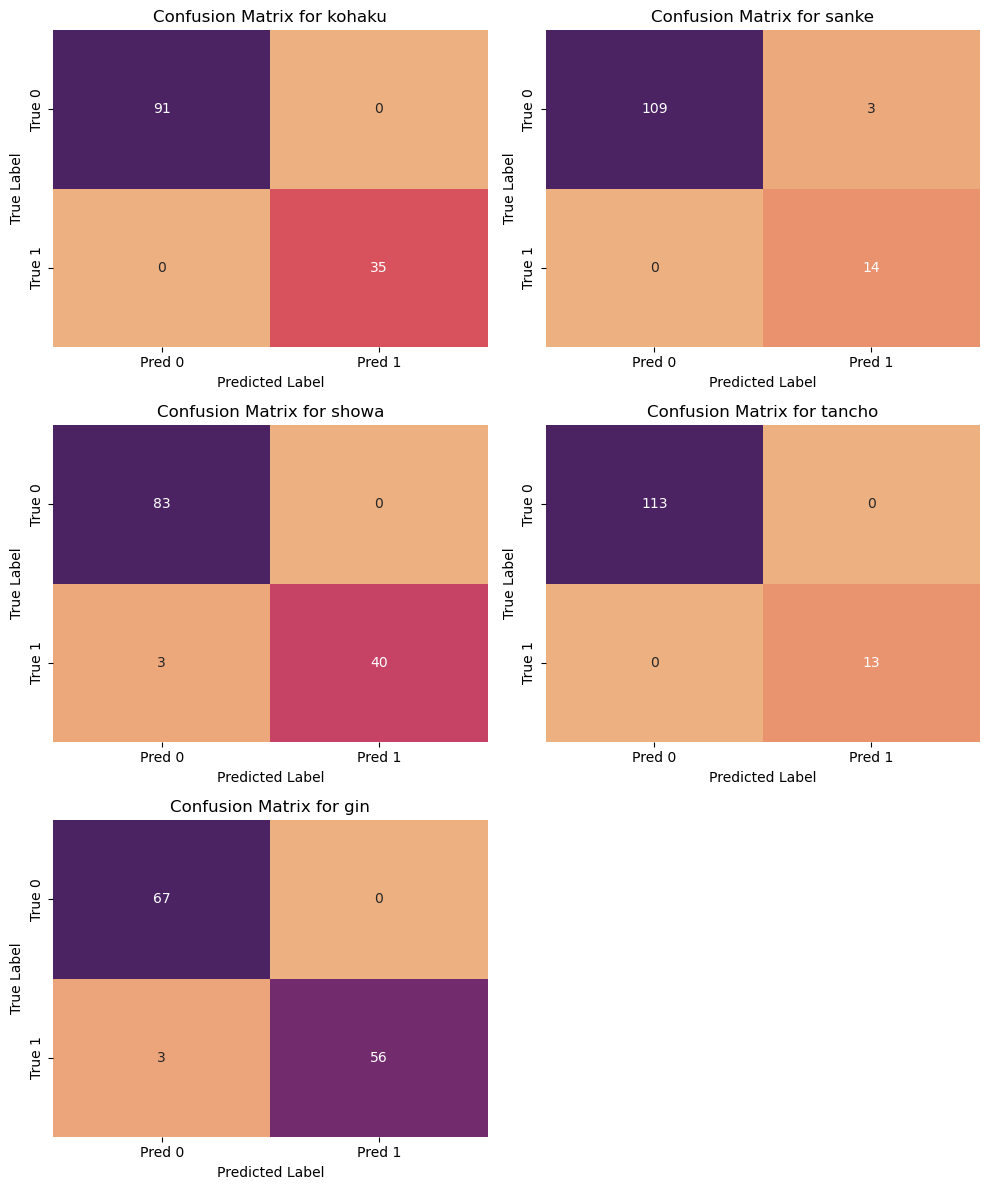

In [21]:
# Evaluate the model

all_preds, all_labels, scores = evaluate_model_flare(model, val_loader, device, class_labels=LABELS)

In [22]:
# Save the model

torch.save(model.state_dict(), 'models/model_resnet18_3_reducelronplateau_earlystopping.pth')

# MODEL 4: Freeze ResNet18 Layers

In [30]:
# Calculate the class balance

pos_weights = get_class_weights(train_df, device)

# Define the model (with FROZEN layers)

model = get_resnet18_model_frozen(num_classes)

# Define loss and optimizer

criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a scheduler to implement reducing learning rate on plateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Train the model

num_epochs = 100


train_losses, train_accuracies, val_losses, val_accuracies = train_model_earlystop_reducelronplateau(model,
                                                                                                    train_loader,
                                                                                                    val_loader,
                                                                                                    criterion,
                                                                                                    optimizer,
                                                                                                    device,
                                                                                                    scheduler,
                                                                                                    num_epochs=num_epochs,
                                                                                                    patience=5)


label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]
Epoch 1/20 | Train Loss: 2.6065, Train Acc: 75.24% | Val Loss: 2.6510, Val Acc: 76.03% | LR: 0.001000
Epoch 2/20 | Train Loss: 2.0997, Train Acc: 80.20% | Val Loss: 2.1769, Val Acc: 80.16% | LR: 0.001000
Epoch 3/20 | Train Loss: 1.8112, Train Acc: 84.56% | Val Loss: 1.9353, Val Acc: 83.65% | LR: 0.001000
Epoch 4/20 | Train Loss: 1.6548, Train Acc: 87.19% | Val Loss: 1.7413, Val Acc: 86.35% | LR: 0.001000
Epoch 5/20 | Train Loss: 1.4899, Train Acc: 88.59% | Val Loss: 1.6166, Val Acc: 87.14% | LR: 0.001000
Epoch 6/20 | Train Loss: 1.4275, Train Acc: 88.75% | Val Loss: 1.4787, Val Acc: 87.94% | LR: 0.001000
Epoch 7/20 | Train Loss: 1.3275, Train Acc: 90.25% | Val Loss: 1.3824, Val Acc: 89.68% | LR: 0.001000
Epoch 8/20 | Train Loss: 1.2564, Train Acc: 90.68% | Val Loss: 1.3110, Val Acc: 90.48% | LR: 0.001000
Epoch 9/20 | Train Loss: 1.2105, Train Acc: 90.68% | V

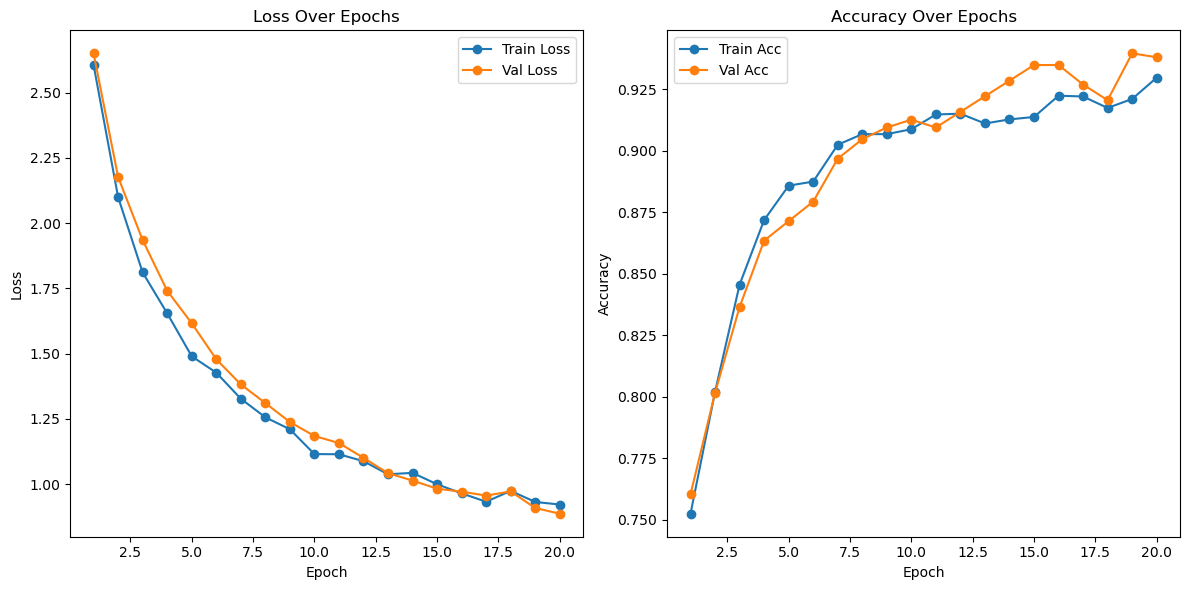

In [31]:
# Plot the train and val losses and accuracies

plot_train_val_losses(len(val_losses), train_losses, train_accuracies, val_losses, val_accuracies)

Validation Accuracy: 0.7460, F1 Score: 0.8279, Precision: 0.9523, Recall: 0.7687
              precision    recall  f1-score   support

      kohaku       0.97      0.89      0.93        35
       sanke       1.00      0.36      0.53        14
       showa       0.87      0.91      0.89        43
      tancho       1.00      0.85      0.92        13
         gin       0.93      0.85      0.88        59

   micro avg       0.93      0.83      0.87       164
   macro avg       0.95      0.77      0.83       164
weighted avg       0.93      0.83      0.87       164
 samples avg       0.87      0.85      0.85       164



/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


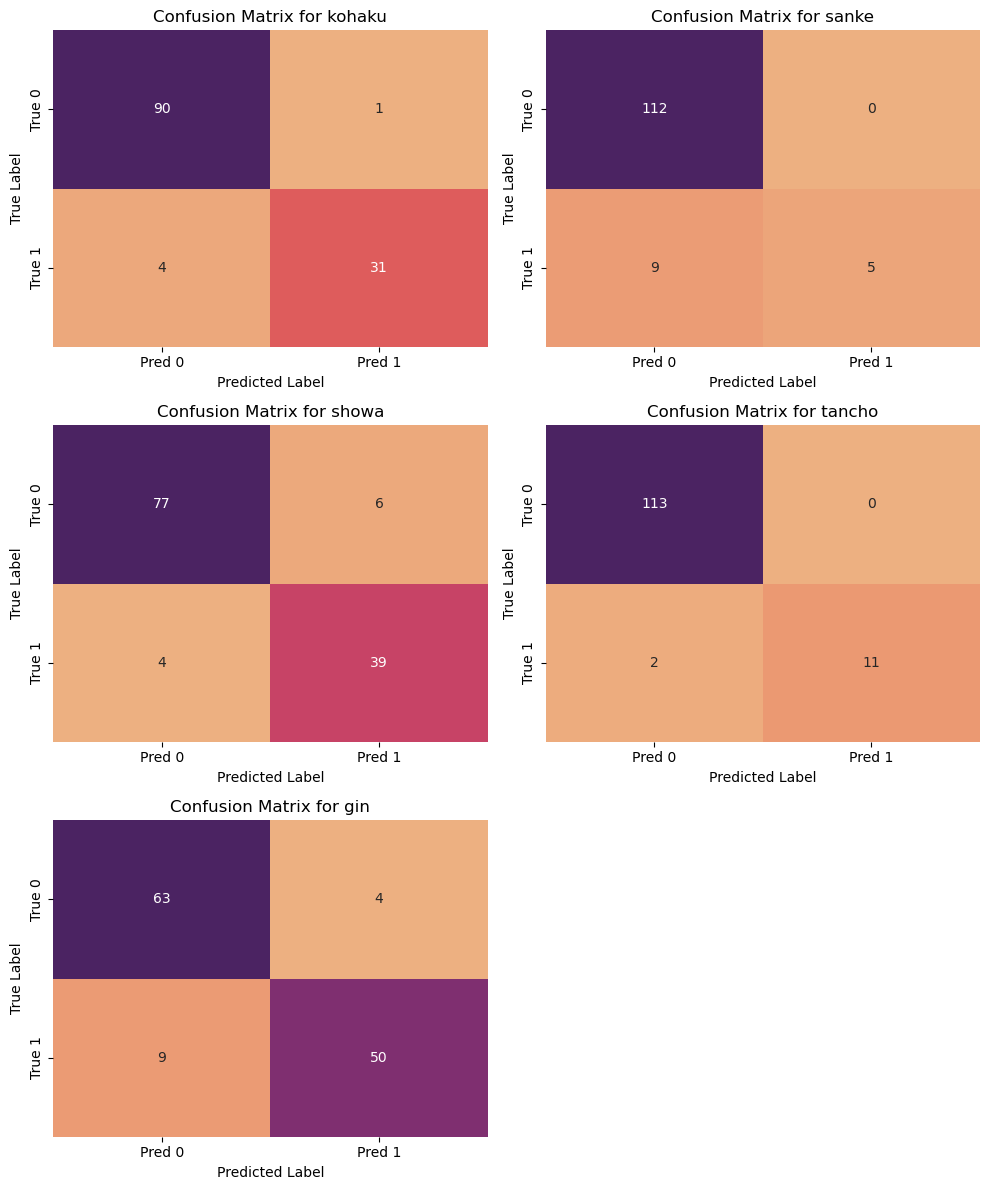

In [32]:
# Evaluate the model

all_preds, all_labels, scores = evaluate_model_flare(model, val_loader, device, class_labels=LABELS)

In [ ]:
# Save the model

torch.save(model.state_dict(), 'models/model_resnet18_4_frozen_layers.pth')